# Identify Factors that Predict Intro CS Experience Based on Gender


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import libraries
from __future__ import division
import sys
sys.path.append('tools/')

import numpy as np
import pandas as pd
import pickle
import tools

   
# Graphing Libraries
import matplotlib.pyplot as pyplt
import seaborn as sns
sns.set_style("white")    

## Problem Statement

With this project, the problem I am interested in investigating is the gendered experience of the two CS classes in the study. Using machine learning algorithms, I want to identify the leading indicators of the experience of belonging broken down by gender in introductory CS at an elite research university like Berkeley.

To solve this problem, I will undertake the following course of action:
- Explore the dataset.
    - Usually, I would explore the dataset to ensure its integrity and understand the context. But in this case, I will skip this step since I designed the study and collected the data, as such, I am well versed of the context. Further, I have done previous work on this dataset, so I know its boundaries.
- Identify features that may be used. 
    - If possible, engineer features that might provide greater discrimination.
- With the understanding that this a `classification` task, explore a couple of classifiers that might be well suited for the problem at hand.
- Once a classifier has been selected, tune it for optimality.

## Exploring the Data

Let's go ahead and read in the student dataset first.


In [3]:
dataset = tools.preprocess()

In [4]:
tools.dataDescr()

UC Berkeley Intro CS Student dataset

Notes
------
Data Set Characteristics:

Number of Instances:882

Attribute Information:

Self reported attitudes about CS
- atcs_1 I like to use computer science to solve problems.
- atcs_2 I can learn to understand computing concepts.
- atcs_3 I can achieve good grades (C or better) in computing courses.
- atcs_4 I do not like using computer science to solve problems.
- atcs_5 I am confident that I can solve problems by using computation.
- atcs_6 The challenge of solving problems using computer science appeals to me.
- atcs_7 I am comfortable with learning computing concepts.
- atcs_8 I am confident about my abilities with regards to computer science.
- atcs_9 I do think I can learn to understand computing concepts.

Gendered belief about CS ability
- atcsgender_1 Women are less capable of success in CS than men.
- atcsgender_2 Women are smarter than men.
- atcsgender_3 Men have better math and science abilities than women.

Career driven beliefs

In [5]:
tools.dataLookUp('atct_8')

I know how to write a computer program to solve a problem.


In [6]:
dataset = dataset.query('gender == "Female" or gender == "Male"')
dataset = dataset.reset_index(drop=True)


print '{:d}{:20}{:d}{:20}'.format(len(dataset.query('gender == "Male"')), ' male students, and ',
                                  len(dataset.query('gender == "Female"')),
                                  ' female students consented to participate in this study')
                        

494 male students, and 388 female students consented to participate in this study


In [7]:
dataset.drop(['major'], axis=1, inplace=True)

## Preprocess Data

### Preprocess feature columns
To prepare our data for classification, we need to devise a scheme to transform all features into numeric data. This dataset as several non-numeric columns that need converting. Many of them are simply `yes`/`no`, e.g. `prcs_2`. We can reasonably convert these into `1`/`0` (binary) values. For the columns whose values are `Nan`, we will convert these to `0`. 


**Note**: These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [8]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['Yes', 'No'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            # e.g. 'reason' => 'reason_class_Interested' , 'reason_class_Other'
            col_data = pd.get_dummies(col_data, prefix=col)

        outX = outX.join(col_data)  # collect column(s) in output dataframe
        outX.fillna(0, inplace=True) # make sure all NaN <missing> values are set to 0

    return outX



In [9]:
dataset = preprocess_features(dataset)
print "Processed feature columns ({}):- {}".format(len(dataset.columns), list(dataset.columns))


Processed feature columns (47):- ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9', 'atcsgender_1', 'atcsgender_2', 'atcsgender_3', 'atcsjob_1', 'atcsjob_2', 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8', 'blg_1', 'blg_2', 'blg_3', 'blg_4', 'classmtr', 'clet_1', 'clet_2', 'cltrcmp_1', 'cltrcmp_2', 'gender_Female', 'gender_Male', 'grade_B or above', 'grade_B or below', 'mtr_1', 'mtr_2', 'mtr_3', 'prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5', 'prepared', 'priorcs10', 'reason_class_Interested', 'reason_class_Other']


### Preprocess feature columns - Rename columns

There are some columns that have spaces in their names, these makes it difficult for the tree plotting algorithms that we will be using later to graph these features. As a result, we will change these spaces to hypens.

In [10]:
dataset.rename(columns = {'grade_B or above':'grade_B_or_above'}, inplace = True)
dataset.rename(columns = {'grade_B or below':'grade_B_or_below'}, inplace = True)

### Scaling
Linearly scale each attribute to the range [0, 1].



In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
dataset = df_scaled
dataset.tail()


,atcs_1,atcs_2,atcs_3,atcs_4,atcs_5,atcs_6,atcs_7,atcs_8,atcs_9,atcsgender_1,...,mtr_3,prcs_1,prcs_2,prcs_3,prcs_4,prcs_5,prepared,priorcs10,reason_class_Interested,reason_class_Other
877,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.0,1.0,0.0
878,0.00,0.50,0.25,1.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0
879,1.00,1.00,1.00,0.25,0.75,1.00,1.00,0.75,1.00,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.00,0.0,0.0,0.0
880,1.00,1.00,0.75,0.25,0.50,0.75,0.50,0.50,0.75,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0
881,0.75,0.75,0.50,0.25,0.25,1.00,0.75,0.50,1.00,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.25,0.0,1.0,0.0


### Frequency Distribution

Create the dimension that we are interested in investigating.

In [121]:
mtr = ['mtr_1', 'mtr_2', 'mtr_3'] # CS Mentors
prcs = ['prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5'] # Prior CS Exposure
atcs = ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_5', 'atcs_4', 
        'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9']# self reported attitude about CS competency
atct = ['atct_1', 'atct_2', 'atct_3', 'atct_4', 
        'atct_5', 'atct_6', 'atct_7', 'atct_8'] # Self reported attitudes about computational thinking
blg = ['blg_1', 'blg_2', 'blg_3', 'blg_4'] # Sense of belonging in the class room
clet = ['clet_1', 'clet_2'] # Social implications and ethics
atcsgender = ['atcsgender_1', 'atcsgender_2', 'atcsgender_3'] 
atcsjob = ['atcsjob_1', 'atcsjob_2'] 
cltrcmp = ['cltrcmp_1', 'cltrcmp_2'] # Culutral competency
priorcs10 = 'priorcs10' # had taken CS10 prior


## Summarizing Data

For the majority of this plots, we can see that they are not normally distributed. Most of the data is either skewed to the left or skewed to the right. This lets us know that we can not rely of descriptive statistics like the mean to make sense of the data.

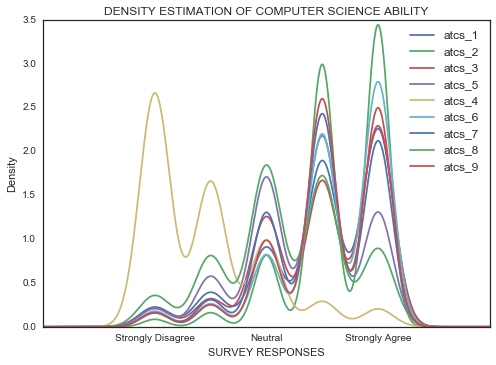

In [122]:
dataset[atcs].plot(kind='kde')

x = [-0.5, 0.0, 0.5, 1.0, 1.5]
labels = ["", "Strongly Disagree", "Neutral", "Strongly Agree" , ""]
pyplt.xticks(x, labels)

pyplt.xlabel('SURVEY RESPONSES')
pyplt.title('DENSITY ESTIMATION OF COMPUTER SCIENCE ABILITY')
pyplt.legend(loc='upper right', shadow=True, fontsize='medium')
pyplt.savefig('report/figures/atcs_kde.pdf', dpi=100)

In [123]:
dataset[atcs].quantile(0.50)

atcs_1    0.75
atcs_2    0.75
atcs_3    0.75
atcs_5    0.75
atcs_4    0.25
atcs_6    0.75
atcs_7    0.75
atcs_8    0.50
atcs_9    0.75
dtype: float64

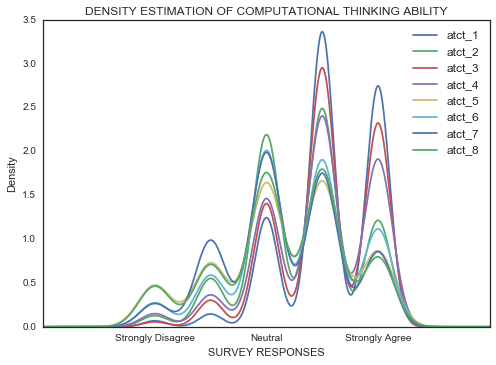

In [16]:
dataset[atct].plot(kind='kde')

x = [-0.5, 0.0, 0.5, 1.0, 1.5]
labels = ["", "Strongly Disagree", "Neutral", "Strongly Agree" , ""]
pyplt.xticks(x, labels)

pyplt.xlabel('SURVEY RESPONSES')
pyplt.title('DENSITY ESTIMATION OF COMPUTATIONAL THINKING ABILITY')
pyplt.legend(loc='upper right', shadow=True, fontsize='medium')
pyplt.savefig('report/figures/atct_kde.pdf', dpi=100)

In [117]:
dataset[atct].quantile(0.50)

atct_1    0.75
atct_2    0.75
atct_3    0.75
atct_4    0.75
atct_5    0.50
atct_6    0.75
atct_7    0.50
atct_8    0.50
dtype: float64

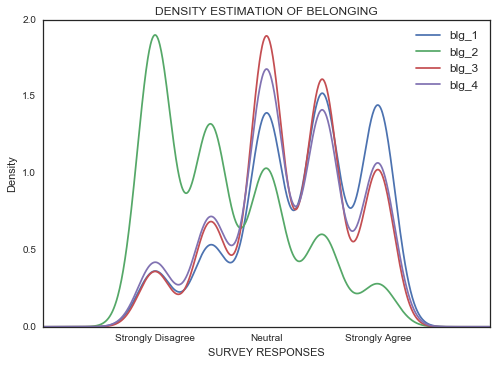

In [18]:
dataset[blg].plot(kind='kde')

x = [-0.5, 0.0, 0.5, 1.0, 1.5]
labels = ["", "Strongly Disagree", "Neutral", "Strongly Agree" , ""]
pyplt.xticks(x, labels)

pyplt.xlabel('SURVEY RESPONSES')
pyplt.title('DENSITY ESTIMATION OF BELONGING')
pyplt.legend(loc='upper right', shadow=True, fontsize='medium')
pyplt.savefig('report/figures/blg_kde.pdf', dpi=100)

In [108]:
dataset[blg].quantile(.50)

blg_1    0.75
blg_2    0.25
blg_3    0.50
blg_4    0.50
dtype: float64

In [55]:
dataset[atcsgender].describe().ix['50%']

atcsgender_1    0.00
atcsgender_2    0.25
atcsgender_3    0.00
Name: 50%, dtype: float64

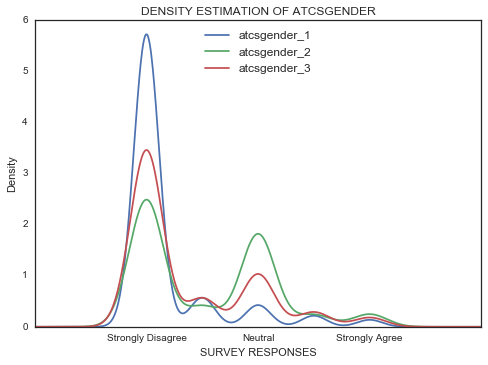

In [20]:
dataset[atcsgender].plot(kind='kde')

x = [-0.5, 0.0, 0.5, 1.0, 1.5]
labels = ["", "Strongly Disagree", "Neutral", "Strongly Agree" , ""]
pyplt.xticks(x, labels)

pyplt.xlabel('SURVEY RESPONSES')
pyplt.title('DENSITY ESTIMATION OF ATCSGENDER')
pyplt.legend(loc='upper center', shadow=True, fontsize='medium')
pyplt.savefig('report/figures/atcsgender_kde.pdf', dpi=100)

In [115]:
dataset[atcsgender].quantile(.50)

atcsgender_1    0.00
atcsgender_2    0.25
atcsgender_3    0.00
dtype: float64

In [52]:
tools.dataLookUp('atcsgender_3')

Men have better math and science abilities than women.


As we can see, these variables have fair variability in their distributions. 

### Extract features and labels 

Extract feature (X) and target (y) columns

In [22]:
target_col = dataset['gender_Female']  #  column is the target/label 
y = target_col  # corresponding targets/labels

print "\nLabel values:-"
print y.head()  


Label values:-
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: gender_Female, dtype: float64


In [23]:
X = dataset.drop(['gender_Female', 'gender_Male'], axis=1, inplace=False)

print "\nFeature values:-"
print X.head()  


Feature values:-
   atcs_1  atcs_2  atcs_3  atcs_4  atcs_5  atcs_6  atcs_7  atcs_8  atcs_9  \
0     0.5    0.75    1.00    0.50    0.75    0.75    0.75    0.50    0.75   
1     0.0    0.00    0.00    1.00    0.00    0.00    0.00    0.00    0.25   
2     1.0    1.00    1.00    0.00    1.00    1.00    1.00    1.00    1.00   
3     1.0    0.75    0.75    0.00    0.75    0.75    0.75    1.00    1.00   
4     0.5    0.50    0.75    0.25    0.50    0.75    1.00    0.25    0.75   

   atcsgender_1         ...          mtr_3  prcs_1  prcs_2  prcs_3  prcs_4  \
0           0.0         ...            0.0     0.0     0.0     0.0     0.0   
1           0.0         ...            0.0     0.0     0.0     1.0     1.0   
2           0.0         ...            1.0     0.0     0.0     0.0     0.0   
3           0.0         ...            0.0     0.0     0.0     0.0     0.0   
4           0.0         ...            0.0     0.0     0.0     0.0     0.0   

   prcs_5  prepared  priorcs10  reason_class_Inter

In [24]:
## Make sure we drop the target from the table, otherwise we will be including the labeled data

print "Feature column(s):-", list(X)

Feature column(s):- ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9', 'atcsgender_1', 'atcsgender_2', 'atcsgender_3', 'atcsjob_1', 'atcsjob_2', 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8', 'blg_1', 'blg_2', 'blg_3', 'blg_4', 'classmtr', 'clet_1', 'clet_2', 'cltrcmp_1', 'cltrcmp_2', 'grade_B_or_above', 'grade_B_or_below', 'mtr_1', 'mtr_2', 'mtr_3', 'prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5', 'prepared', 'priorcs10', 'reason_class_Interested', 'reason_class_Other']


### Determine if classes are balanced
- As we can see the dataset is unbalanced, we have more males than females.




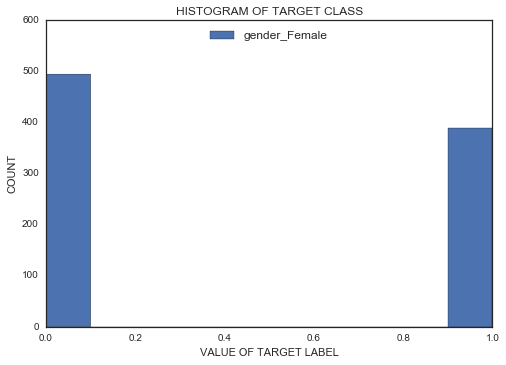

In [25]:
y.plot.hist()

pyplt.grid(False)
_= pyplt.xlabel('VALUE OF TARGET LABEL')
_= pyplt.ylabel('COUNT')
_= pyplt.title('HISTOGRAM OF TARGET CLASS')
_= pyplt.legend(loc='upper center', shadow=True, fontsize='medium')
_= pyplt.yticks(np.arange(0, 700, 100))
pyplt.savefig('report/figures/targetClass.pdf', dpi=100)


In [26]:
num_male = y.tolist().count(0)
num_female = y.tolist().count(1)


print "number of males in data", num_male
print "number of females in data", num_female


print "ration of males to females {}".format(num_male/ num_female)


number of males in data 494
number of females in data 388
ration of males to females 1.27319587629


In [27]:
# First, decide how many training vs test samples you want
num_all = X.shape[0]  # same as len(student_data)
num_train = 662  # about 75% of the data
num_test = num_all - num_train

In [28]:
num_train

662

In [29]:
from sklearn import cross_validation



def shuffle_split_data(X, y):
    """ Shuffles and splits data into 75% training and 25% testing subsets,
        then returns the training and testing subsets. """
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, 
                                                                        train_size=num_train, random_state=42)
    
    
    


    # Return the training and testing data subsets
    return X_train, y_train, X_test, y_test

In [30]:
try:
    X_train, y_train, X_test, y_test = shuffle_split_data(X, y)
    print "Successfully shuffled and split the data!"
except:
    print "Something went wrong with shuffling and splitting the data."


print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])


Successfully shuffled and split the data!
Training set: 662 samples
Test set: 220 samples


## Modeling and Validating




I have created four separate tranches to investigate the data:
- All features
- A reduced dataset of features

## Train on all features

In [31]:
X = X_train

seed = 342 # For reproducability
folds = 50

In [32]:

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import validation_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics



models = {
          'XGBoost': XGBClassifier(),
          'DecisionTree': DecisionTreeClassifier(),
          'SVC': svm.SVC(),
          'RandomForest': RandomForestClassifier()
         }


In [33]:
for model_name, model in models.iteritems():
    print model_name
    kfold = StratifiedKFold(y_train, n_folds=folds, random_state=np.random.seed(seed))
    results = cross_val_score(model, X, y_train, cv=kfold, scoring='f1')
    print("Training data accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'
    
   

RandomForest
Training data accuracy: 50.90% (18.37%) 

DecisionTree
Training data accuracy: 48.15% (19.63%) 

XGBoost


/Users/omojumiller/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training data accuracy: 56.43% (19.36%) 

SVC
Training data accuracy: 54.20% (18.32%) 



### Predict 

RandomForest
F1 score: 0.608%


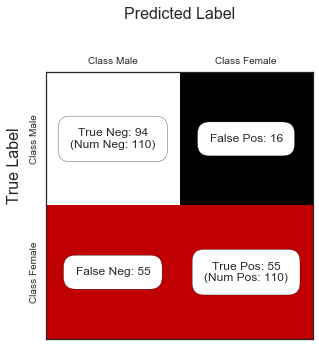

DecisionTree
F1 score: 0.579%


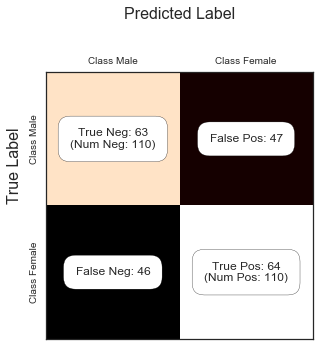

XGBoost
F1 score: 0.693%


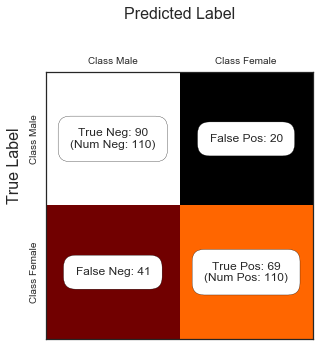

SVC
F1 score: 0.541%


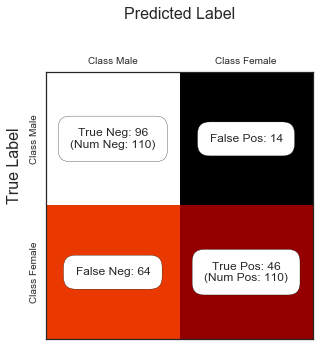

In [34]:
Features_test = X_test

for model_name, model in models.iteritems():
    print model_name
    # make predictions for test data
    model.fit(X, y_train)
    y_pred = model.predict(Features_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    
    print "F1 score: %.3f%%"% (metrics.f1_score(y_test, predictions))
    
    C = confusion_matrix(y_test, predictions)
    tools.show_confusion_matrix(C, 'report/figures/'+model_name+'.pdf', ['Class Male', 'Class Female'])

## Plot Decision Tree

In [35]:
import subprocess

def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("report/figures/dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f, feature_names=feature_names, filled=True, rounded=True,  
                         special_characters=True)
    command = ["dot", "-Tpng", "report/figures/dt.dot", "-o", "report/figures/dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [37]:
dt = DecisionTreeClassifier(random_state=np.random.seed(seed))
dt.fit(X, y_train)

visualize_tree(dt, X.columns)

### Select XGBoost classifier
- Plot first two xgboost trees to see which features were doing the most work of splitting the data
- Generate Features from XGBoost classifier 

In [38]:
model = XGBClassifier()
model.fit(X, y_train)
g = xgb.to_graphviz(model, num_trees=2, rankdir='LR')
g.render('report/figures/X_graph', view=True)

'report/figures/X_graph.pdf'

We are just displaying the first two trees here.   

On simple models the first two trees may be enough. XGBoost generate `k` trees at each round for a `k`-classification problem.

# Tune Estimator

### Ideal choices of parameters as taken from Xgboost With Python ebook

- Number of Trees (`n_estimators`) set to a fixed value between 100 and 1000, depending on the dataset size.
- Learning Rate (`learnin_rate`) simplified to the ratio: [2 to 10]/trees, depending on the trees number of trees.
- Row Sampling (`subsample`) grid searched values in the range [0.5, 0.75, 1.0].
- Column Sampling (`colsample` bytree and maybe colsample bylevel) grid searched values in the range [0.4, 0.6, 0.8, 1.0].
- Min Leaf Weight (`min_child_weight`) simplified to the ratio 3/rare_events , where rare events rare events is the percentage of rare event observations in the dataset.
- Tree Size (`max_depth`) grid searched values in the rage [4, 6, 8, 10].
- Min Split Gain (`gamma`) fixed with a value of zero.


In [40]:
X = X_train

In [41]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import f1_score, make_scorer
from xgboost.sklearn import XGBClassifier



default_params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3
}


n_estimators_range = np.linspace(1, 200, 10).astype('int') 

# Build a stratified shuffle object because of unbalanced data
folds = 50
ssscv = StratifiedShuffleSplit(y_train, folds, random_state=np.random.seed(seed))


train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y_train,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=ssscv,
    scoring='accuracy'
)


 Show the validation curve plot

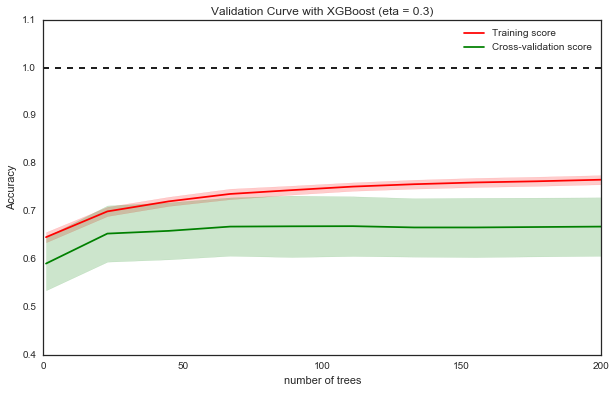

Best cross-validation result (0.67) obtained for 111 trees


In [42]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], 
                                                                             n_estimators_range[i]))

fig.savefig('report/figures/varianceCurve_1.pdf', format='pdf')


Looking at the plot we can draw the following conclusions:
- training score keeps growing while adding new trees, but from a certain point CV score is fixed
- variance is lowest, and bias is high for less than 25 trees,
- we can see that the model is quite stable keeping variance fixed when increasing it's complexity   

We can assume that the trade-off for our model will be met at n_estimators = 50. The variance is still to big.


Tweak parameters
- To reduce a variance:  
    - each tree we will use 70% randomly chosen samples
    - 60% randomly chosen features   
    
- To decrease the bias (bigger accuracy):
    - Add an extra level to each tree


In [43]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 2, # changed
    'learning_rate': 0.3,
    'colsample_bytree': 0.6, # added
    'subsample': 0.7 # added
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y_train,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=ssscv,
    scoring='accuracy'
)

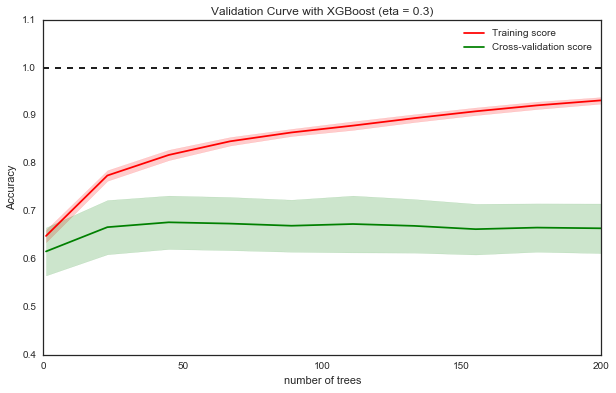

Best cross-validation result (0.68) obtained for 45 trees


In [44]:

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.1)
plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], 
                                                                             n_estimators_range[i]))
fig.savefig('report/figures/varianceCurve_2.pdf', format='pdf')

In [45]:
params_grid = {
            'learning_rate': [0.2222, 0.4444, 0.6666, 0.8888],
            'max_depth': [4, 6, 8, 10],
            'n_estimators': range(100, 1100, 100),
            'colsample_bytree': [0.6],
            'subsample':[0.7]
}

params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

In [46]:
# Load and use already tuned classifier, else tune classifier

tune_flag = False

if tune_flag:
    grid = GridSearchCV(estimator=XGBClassifier(**params_fixed),
        param_grid=params_grid,
        cv=ssscv,
        scoring='f1')
    grid.fit(X, y_train)
    
    print "Best accuracy obtained: {0}".format(grid.best_score_)
    print "Parameters:"
    for key, value in grid.best_params_.items():
        print "\t{}: {}".format(key, value)
    model = grid.best_estimator_
    
    # save model to file
    pickle.dump(model, open("genderedCSExperience.pickle.dat", "wb"))
    
else:    
    model = tools.load_model()
    print model

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.2222, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, n_estimators=600, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.7)


In [47]:
Features_test = X_test

# make predictions for test data
model.fit(X, y_train)
y_pred = model.predict(Features_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
print "F1 score: %.2f%%"% (f1_score(y_test, predictions))

F1 score: 0.72%


In [48]:
model.fit(X, y_train)
g = xgb.to_graphviz(model, num_trees=2, rankdir='LR')
g.render('report/figures/Tuned_model_graph', view=True)

'report/figures/Tuned_model_graph.pdf'

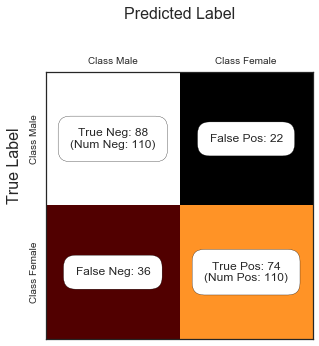

In [49]:
C = confusion_matrix(y_test, predictions)
tools.show_confusion_matrix(C, 'report/figures/tuned_model_CM.pdf', ['Class Male', 'Class Female'])